In [8]:
import zipfile

ZIP_DATA_FILE = "./titanic.zip"
DESTINY_DATA_FILES = "./data"

with zipfile.ZipFile(ZIP_DATA_FILE, 'r') as zip_ref:
    zip_ref.extractall(DESTINY_DATA_FILES)

In [6]:
import os

for dirname, _, filenames in os.walk(DESTINY_DATA_FILES):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data\gender_submission.csv
./data\test.csv
./data\train.csv


In [10]:
import pandas as pd
import numpy as np

train_data = pd.read_csv(os.path.join(DESTINY_DATA_FILES, "train.csv"))
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
test_data = pd.read_csv(os.path.join(DESTINY_DATA_FILES, "test.csv"))
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [21]:
mens_survived = train_data.loc[train_data["Sex"] == "male"]["Survived"]
rate_mens_survival = sum(mens_survived)/len(mens_survived)
rate_mens_survival

0.18890814558058924

In [22]:
women_survived = train_data.loc[train_data["Sex"] == "female"]["Survived"]
rate_women_survival = sum(women_survived)/len(women_survived)
rate_women_survival

0.7420382165605095

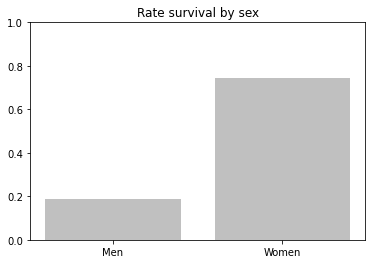

In [40]:
import matplotlib.pyplot as plt

plt.title("Rate survival by sex")
plt.bar(["Men", "Women"], [rate_mens_survival, rate_women_survival], color="silver")
plt.ylim([0, 1])
plt.show()

In [45]:
y = train_data["Survived"]
features = ["Pclass", "Sex", "Age", "SibSp", "Parch"]
X_train = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

In [53]:
X_train.isnull().any()

Pclass        False
Age            True
SibSp         False
Parch         False
Sex_female    False
Sex_male      False
dtype: bool

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ("imputer", SimpleImputer(missing_values=np.nan, strategy='mean')),
    # ("std_scaler", StandardScaler())
])

X_train_tr = pipeline.fit_transform(X_train)
X_test_tr = pipeline.fit_transform(X_test)
X_train_tr

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8], "random_state": [42]},
    {"bootstrap": [False], "n_estimators": [3, 10, 30, 50], "max_features": [2, 4, 6, 8], "random_state": [42]}
]

forest_cls = RandomForestClassifier()
grid_search = GridSearchCV(forest_cls, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_train_tr, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30], 'random_state': [42]},
                         {'bootstrap': [False], 'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30, 50],
                          'random_state': [42]}],
             scoring='neg_mean_squared_error')

In [62]:
grid_search.best_estimator_

RandomForestClassifier(max_features=4, n_estimators=10, random_state=42)

In [64]:
final_model = grid_search.best_estimator_

predictions = final_model.predict(X_test_tr)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [73]:
from sklearn.tree import export_graphviz

export_graphviz(
    final_model.estimators_[5],
    out_file="tree.dot",
    feature_names=["Pclass", "Age", "SibSp", "Parch", "Sex_female", "Sex_male"],
    class_names=["Survived", "Died"],
    rounded=True,
    filled=True
)

#https://dreampuf.github.io/

In [78]:
#Need install graphviz

!dot -Tpng tree.dot -o tree.png